In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from haversine import haversine, Unit

In [2]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

duesseldorf = read_data("duesseldorf").dropna(axis=0)
bremen = read_data("bremen").dropna(axis=0)

# Clustering 

In [3]:


def distance_between_coordinates (trip_data, city_center_lat,city_center_lng):
    trip_data["distance_from_center_start"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    trip_data["distance_from_center_end"] = trip_data.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    X = trip_data.drop(["day","time","b_number","city","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng","avg_speed","rounded_time_hourly","temp","wind","rain","fleetsize_weekly","fleetsize_monthly","fleetsize_dayly","Unnamed: 0","datetime_start","datetime_end","weekday","month","hour","week"], axis=1)
    X.drop(["distance"],axis=1,inplace=True)
    return X   


def calc_revenue(x):
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
        
        
def revenue_distance_from_center (trip_data, city_center_lat,city_center_lng):
    trip_data["distance_from_center_start"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    trip_data["distance_from_center_end"] = trip_data.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    X = trip_data.drop(["day","time","b_number","city","trip_duration_hours","orig_lat","orig_lng","dest_lat","dest_lng","avg_speed","rounded_time_hourly","temp","wind","rain","fleetsize_weekly","fleetsize_monthly","fleetsize_dayly","Unnamed: 0","datetime_start","datetime_end","weekday","month","hour","week"], axis=1)
    X["revenue"] = X["trip_duration"].apply(lambda x: calc_revenue(x) )
    X.drop(["distance","trip_duration"],axis=1,inplace=True)
    return X   

def normalize(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    # create a df out of array
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    X_scaled_df.head()
    return X_scaled_df


def determine_k(X_scaled):
    k_max = 50
    clusters = []
    losses = []
    for k in range(k_max):
        model = KMeans(n_clusters=k+1)
        model.fit(X_scaled)
        clusters.append(k+1)
        losses.append(model.inertia_)
        
    plt.plot(clusters, losses)
    plt.show()    
    plt.plot(clusters, losses)
    plt.xlim([0,15])

def plot_kmeans(name, X,X_scaled,k):
    # refit algorithm
    two_means = KMeans(n_clusters=k)
    two_means.fit(X_scaled)

    # match records to clusters by calling predict
    two_means.predict(X_scaled)
    numbers = ["zero", "one", "two", "three", "five"]
    X["clusters"] = two_means.predict(X_scaled)
    X["clusters"] = X["clusters"].apply(lambda x: numbers[x])
  #  test = X[X["distance_from_center_start"]<20]
    sns_plot = sns.pairplot(data=X, hue="clusters", height = 20)
    sns_plot.savefig("Project_Data/Graphics/Cluster/" + "k_means_"+ name + ".pdf")       

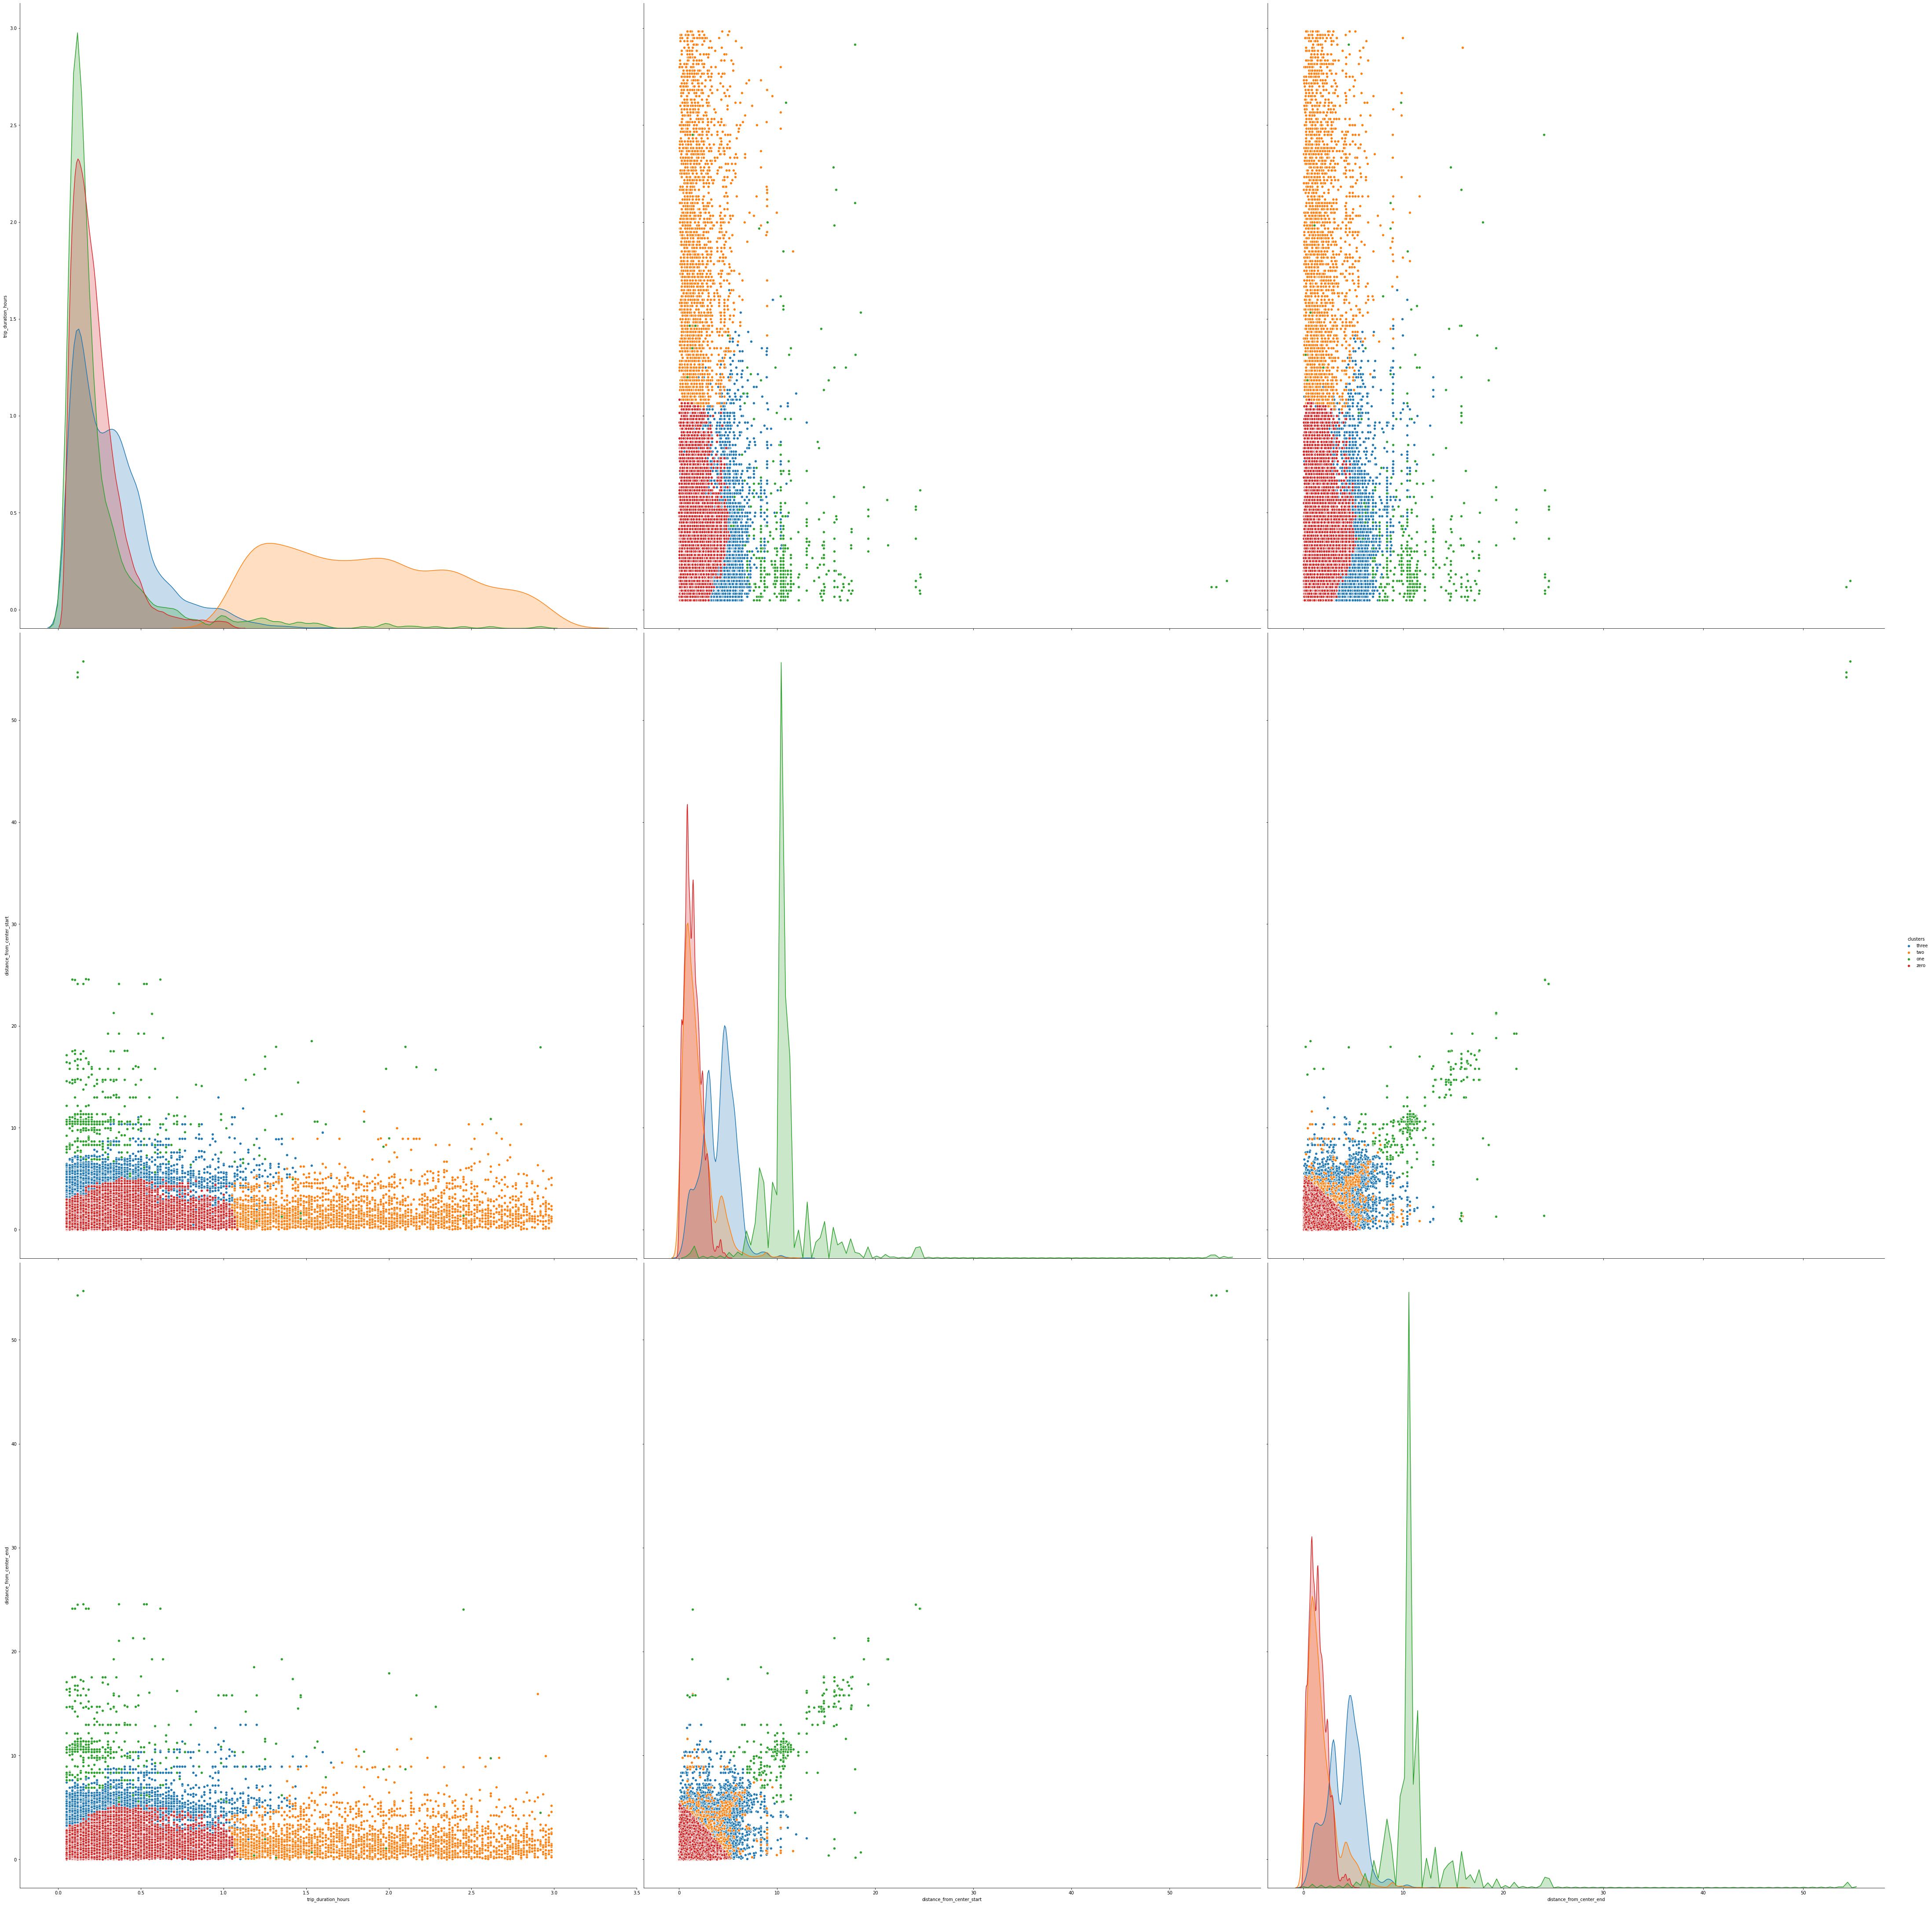

In [4]:
bremen = read_data("bremen")
bremen_d = distance_between_coordinates(bremen,53.075878, 8.807311)
normalized_bremen = normalize(bremen_d)
#determine_k(normalized_bremen)
# k=4
plot_kmeans("bremen_d", bremen_d,normalized_bremen,4)



C:\Users\jan_p\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\jan_p\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\jan_p\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


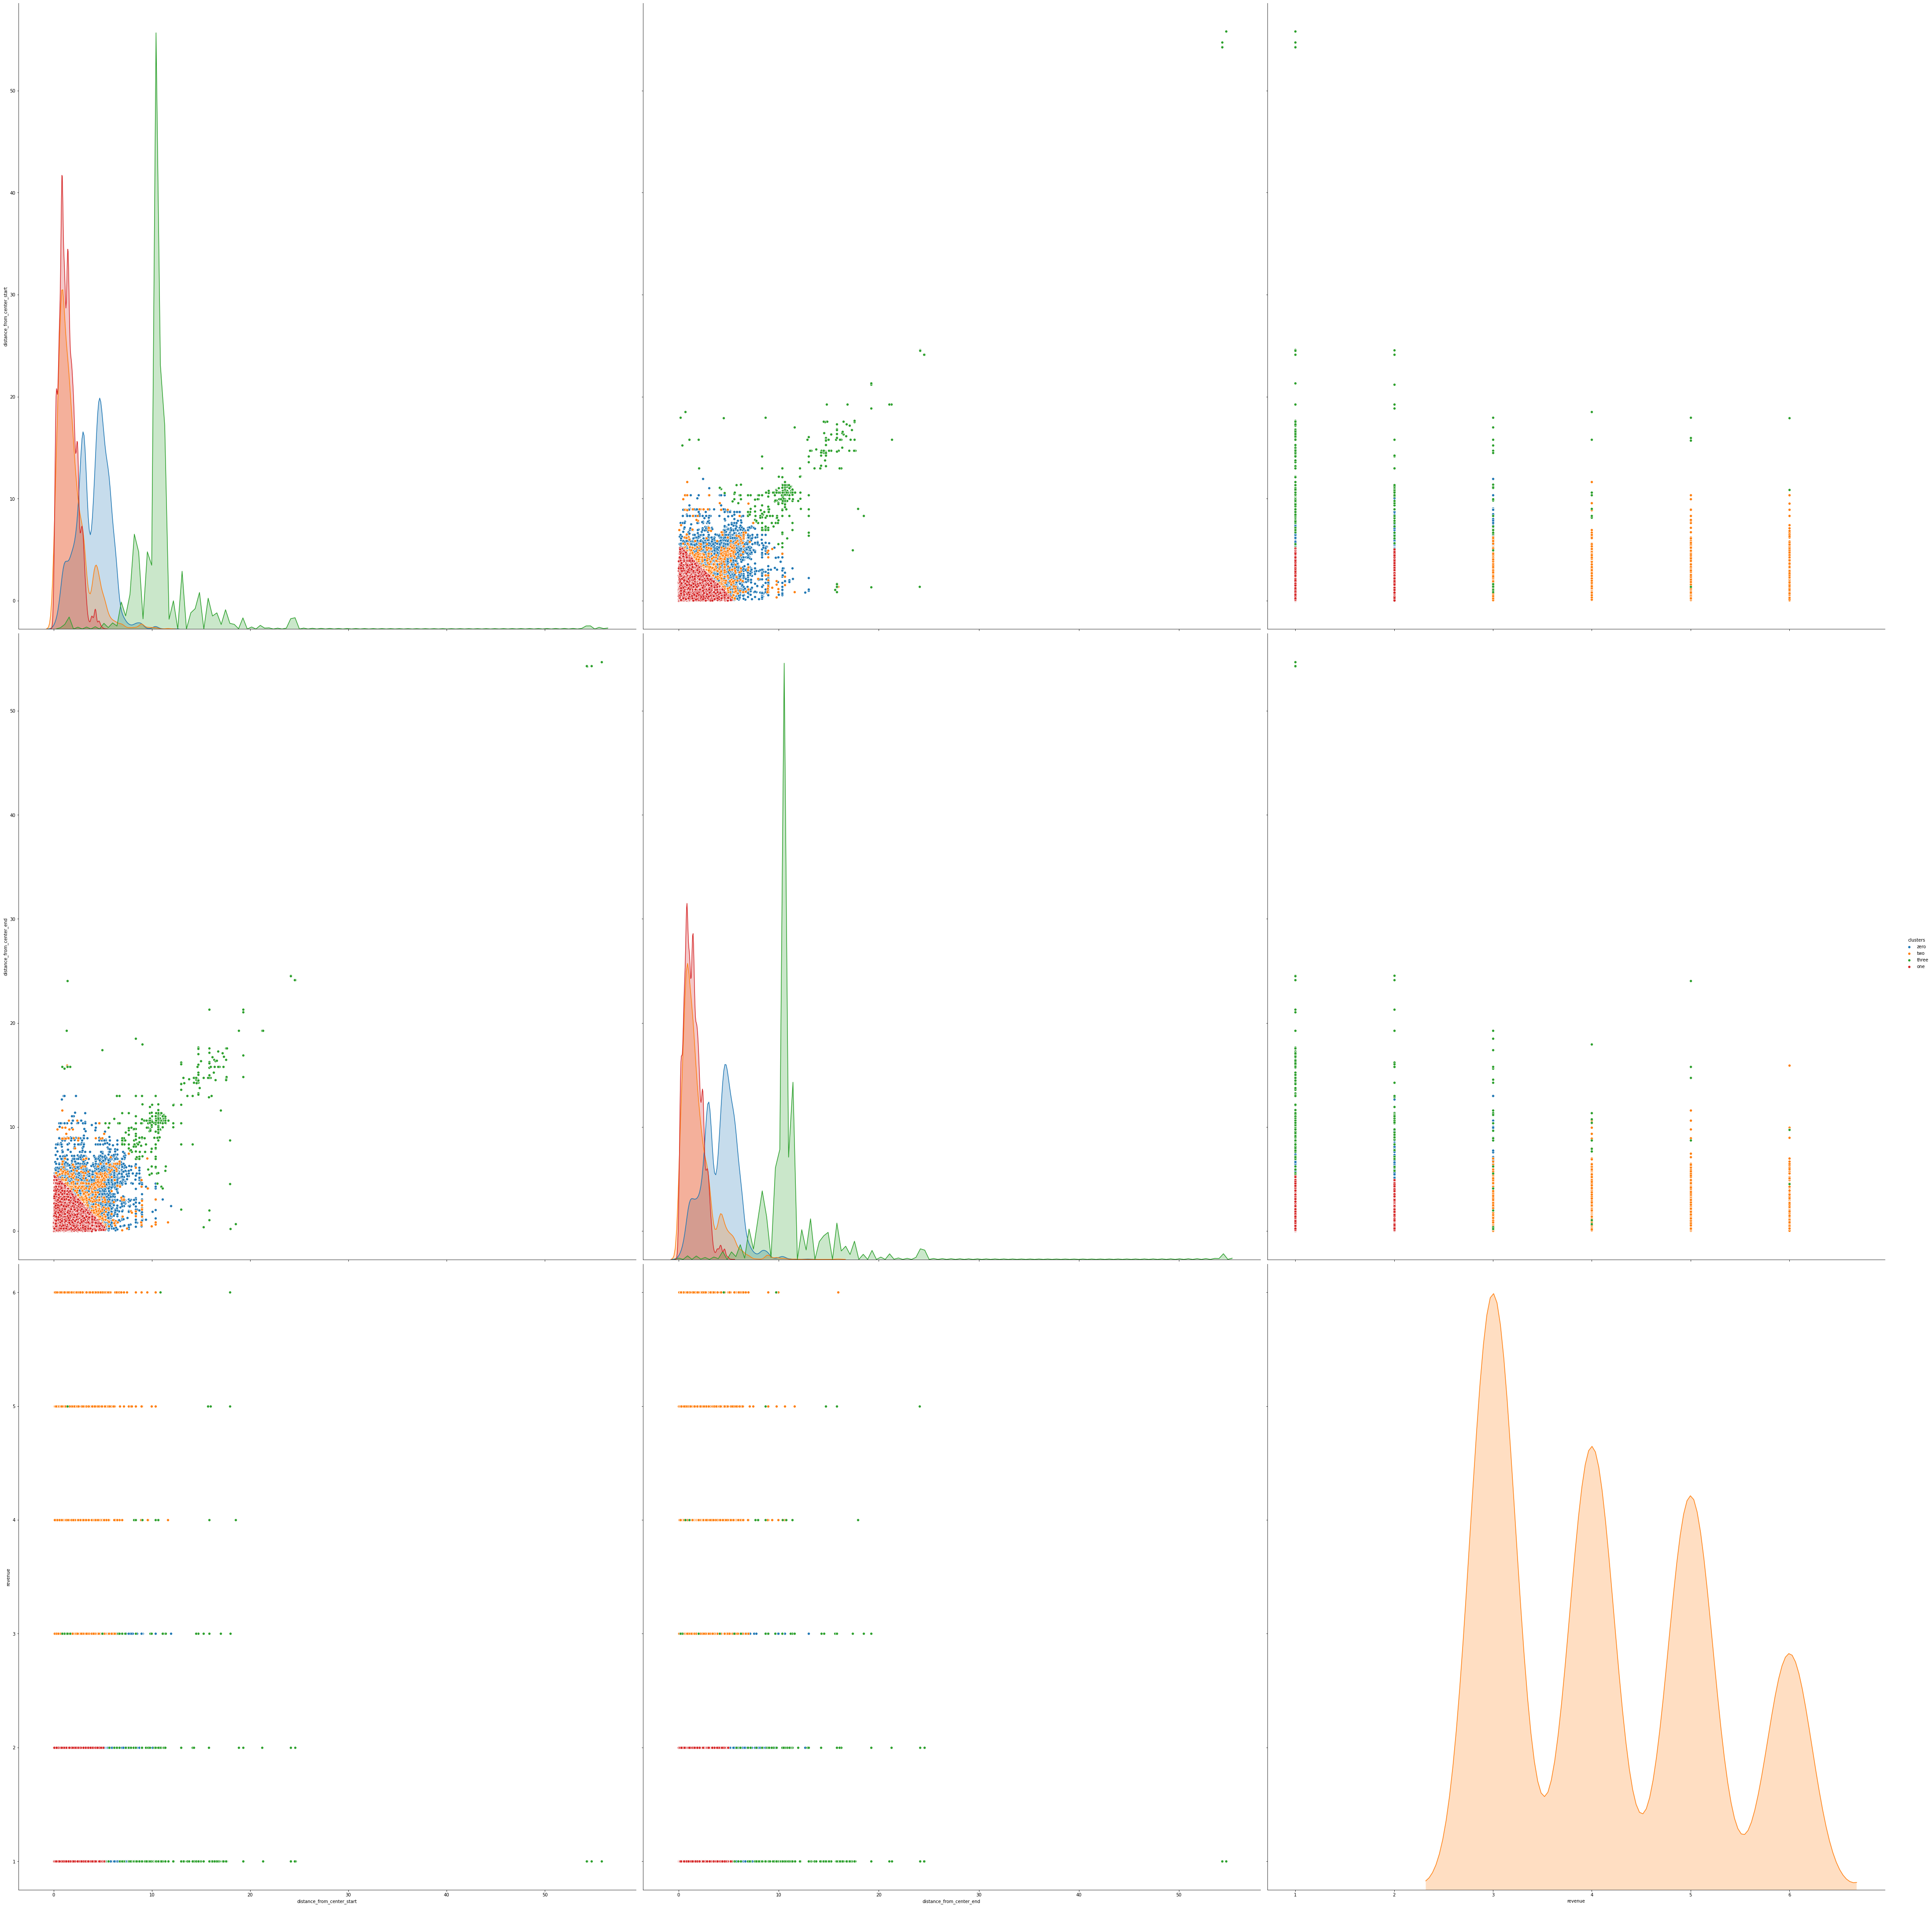

In [5]:
bremen_d_2 = revenue_distance_from_center(bremen,53.075878, 8.807311)
normalized_bremen_2 = normalize(bremen_d_2)
#determine_k(normalized_bremen_2)
# k=4
plot_kmeans("bremen_d_2" ,bremen_d_2,normalized_bremen_2,4)

In [6]:
X = duesseldorf.drop(["day", "time", "city", "trip_duration", "rounded_time_hourly",
                     "datetime_start", "datetime_end", "rounded_time_hourly", "Unnamed: 0",
                     "b_number", "avg_speed", "fleetsize_weekly", "fleetsize_monthly", "fleetsize_dayly",
                     "week", "orig_lat", "orig_lng", "dest_lat", "dest_lng", "weekday", "month",
                     "wind", "rain"], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18038 entries, 0 to 18037
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hour                 18038 non-null  int64  
 1   distance             18038 non-null  float64
 2   trip_duration_hours  18038 non-null  float64
 3   temp                 18038 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 704.6 KB


### Data Prep and Scaling


In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,hour,distance,trip_duration_hours,temp
0,0.321583,0.590130,-0.319682,-1.367538
1,0.321583,0.290374,-0.133326,-1.253682
2,-0.073763,-0.287542,1.637061,-0.015502
3,-1.457475,1.351653,-0.164385,-2.036440
4,0.123910,-0.383103,-0.474979,-0.940579


In [8]:
duesseldorf_scaled = X_scaled_df

### k-means

In [9]:
k_max = 50 

In [10]:
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

(0.0, 10.0)

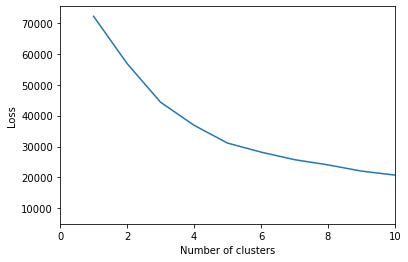

In [11]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

In [12]:
# refit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([0, 0, 0, ..., 1, 1, 1])

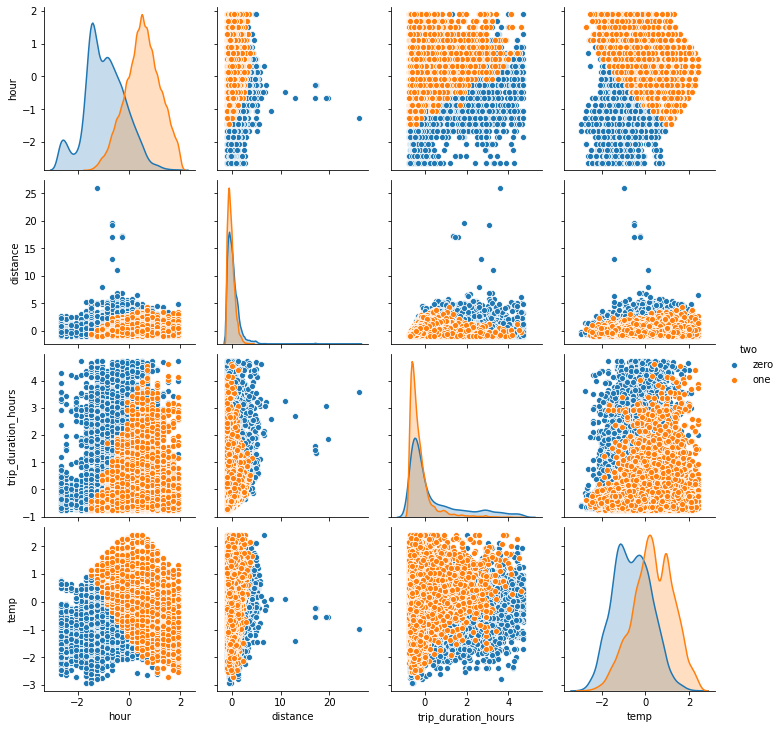

In [13]:
numbers = ["zero", "one", "two", "three"]

duesseldorf_scaled["two"] = two_means.predict(X_scaled)
duesseldorf_scaled["two"] = duesseldorf_scaled["two"].apply(lambda x: numbers[x])
sns_plot_2 = sns.pairplot(data=duesseldorf_scaled, hue="two")
sns_plot_2.savefig("Project_Data/Graphics/Cluster/" + "k_means_"+ "duesseldorf_2_cluster" + ".pdf")       

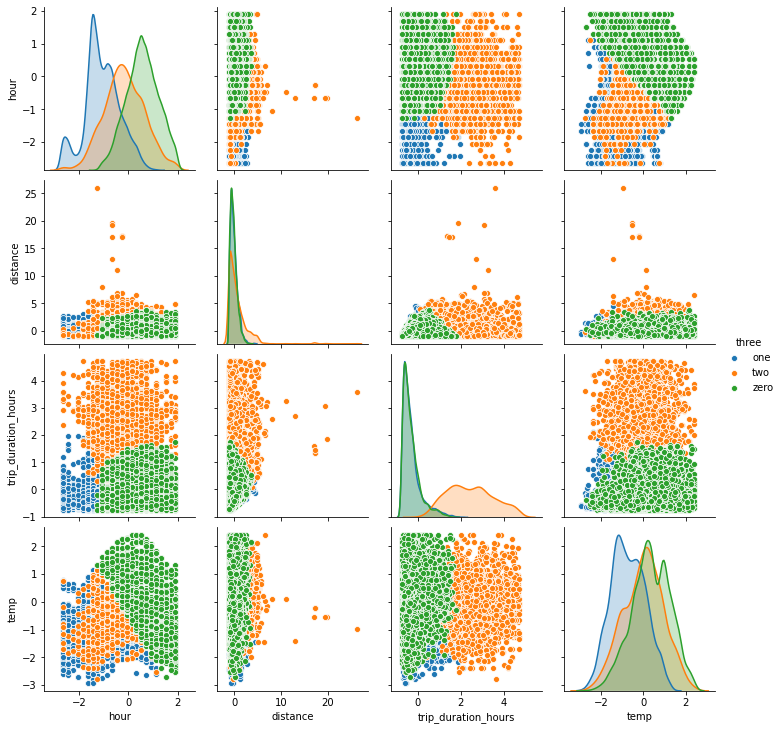

In [14]:
three_means = KMeans(n_clusters=3)
three_means.fit(X_scaled)
duesseldorf_scaled["three"] = three_means.predict(X_scaled)
duesseldorf_scaled["three"] = duesseldorf_scaled["three"].apply(lambda x: numbers[x])
sns_plot_3 = sns.pairplot(data=duesseldorf_scaled, hue="three")
sns_plot_3.savefig("Project_Data/Graphics/Cluster/" + "k_means_"+ "duesseldorf_3_cluster" + ".pdf")       

# PCA Analysis

In [15]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

duesseldorf = read_data("duesseldorf")
bremen = read_data("bremen")

In [16]:
bremen_wo_target = bremen.drop(["day", "time", "city", "trip_duration", "rounded_time_hourly",
                     "datetime_start", "datetime_end", "rounded_time_hourly", "Unnamed: 0",
                       "fleetsize_weekly", "fleetsize_monthly", "fleetsize_dayly"
                     ], axis=1)

### Scaled dataset bremen

In [17]:
scaler = StandardScaler()

bremen_scaled = pd.DataFrame(scaler.fit_transform(bremen_wo_target))
bremen_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.733013,0.052755,2.309151,0.040096,2.753492,1.591161,-0.340210,0.770594,-0.299215,-0.512654,-0.275384,-0.645520,0.904379,-1.211424,-0.140957
1,-1.733013,0.052755,2.309151,-0.003631,1.971327,0.024490,0.406195,0.389097,0.550648,-0.839654,-0.517670,-0.621686,0.947427,-1.023798,-0.140957
2,-1.733013,0.052755,2.309151,-0.206180,1.943354,0.546714,1.152600,1.724334,1.060567,-0.690467,-0.477289,-0.354698,0.789584,-0.085668,-0.140957
3,-1.733013,-0.210255,2.000564,0.053206,2.245269,1.591161,1.152600,-0.564643,1.060567,-0.690467,4.126139,-1.828968,1.076571,-0.742359,-0.140957
4,-1.733013,0.052755,2.309151,-0.113083,2.462562,1.591161,1.152600,-0.183147,1.060567,-0.859359,4.974139,-1.871447,1.105270,-0.085668,-0.140957


In [18]:
bremen_scaled_df = pd.DataFrame(bremen_wo_target, columns=bremen_wo_target.columns, index=bremen_wo_target.index)
bremen_scaled_df.head()

,b_number,orig_lat,orig_lng,dest_lat,dest_lng,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,temp,wind,rain
0,20507,53.078923,8.884911,53.078711,8.899906,6,4,17,16,1.001900,0.216667,4.624155,20.4,2.0,0.0
1,20507,53.078923,8.884911,53.078004,8.876828,3,5,15,21,0.549476,0.116667,4.709793,20.7,2.4,0.0
2,20507,53.078923,8.884911,53.074731,8.876003,4,6,22,24,0.755886,0.133333,5.669146,19.6,4.4,0.0
3,20507,53.074731,8.876003,53.078923,8.884911,6,6,10,24,0.755886,2.033333,0.371747,21.6,3.0,0.0
4,20507,53.078923,8.884911,53.076236,8.891322,6,6,12,24,0.522213,2.383333,0.219110,21.8,4.4,0.0


selection 12 out of 14 columns can explain 0,96% of variance

In [19]:
pca = PCA(n_components=12)
bremen_scaled_pca = pca.fit_transform(bremen_scaled)

In [20]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.17651633 0.12059327 0.11062024 0.09927729 0.08049874 0.073688
 0.06798895 0.06579972 0.06558504 0.05544731 0.0237231  0.02265953]
0.9623975061638205


variance of the components

### calculation of optimal cluster number

(0.0, 10.0)

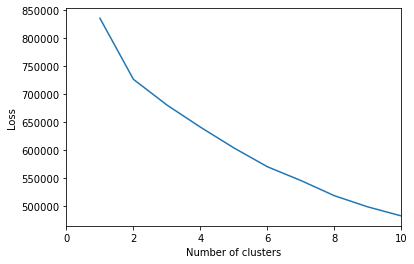

In [21]:
clusters = []
losses = []
k_max = 10

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(bremen_scaled_pca)
    clusters.append(i+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

### cluster analysis with 5 clusters

In [22]:
bremen_five = KMeans(n_clusters=5)
bremen_five.fit(bremen_scaled_pca)

KMeans(n_clusters=5)

In [23]:
bremen_five.predict(bremen_scaled_pca)

array([4, 4, 4, ..., 2, 4, 4])

In [24]:
bremen_scaled_pca_df = pd.DataFrame(bremen_scaled_pca, index=bremen.index)
bremen_scaled_pca_df.columns = ["PC"+str(column+1) for column in bremen_scaled_pca_df.columns]

In [25]:
bremen_scaled_pca_df["Cluster"] = bremen_five.predict(bremen_scaled_pca)
bremen_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster
0,-0.672804,-2.297922,1.561860,2.484060,-0.272757,1.682476,-0.206683,-1.547773,1.215455,-0.125809,0.578899,0.777858,4
1,-1.429934,-2.012065,0.989998,1.724146,0.722413,1.396513,0.506513,-1.440235,0.489889,-0.845979,-0.052403,0.561371,4
2,-2.106277,-2.167923,1.059514,1.718839,1.027487,0.617833,-0.477905,-1.707765,1.116926,-0.222684,-0.407981,-0.172260,4
3,-2.761186,-1.791321,-0.068850,4.134481,-2.624928,0.003038,1.692752,-0.604970,0.128369,0.036813,0.197007,-0.229282,0
4,-2.857890,-1.961402,-0.096469,4.881823,-2.603149,-0.738586,1.599725,-0.599232,0.118490,0.239738,0.082782,-0.252998,0


# 5 Cluster
### cluster for the most relevant varinace factors PC1, PC2 and PC3

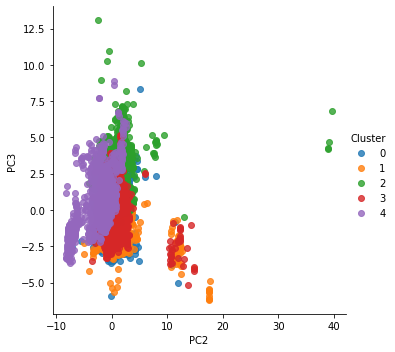

In [26]:
sns_pc_plot1 = sns.lmplot(x="PC2", y="PC3", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot1.savefig("Project_Data/Graphics/Cluster/" + "sns_pc_plot1" + ".pdf")       

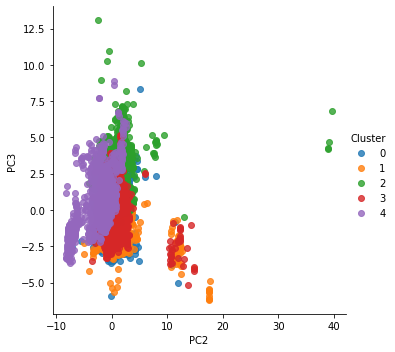

In [27]:
sns_pc_plot2 = sns.lmplot(x="PC2", y="PC3", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot2.savefig("Project_Data/Graphics/Cluster/"+ "sns_pc_plot2" + ".pdf")       

# 3 Cluster

In [28]:
bremen_three = KMeans(n_clusters=3)
bremen_three.fit(bremen_scaled_pca)

KMeans(n_clusters=3)

In [29]:
bremen_three.predict(bremen_scaled_pca)

array([2, 2, 2, ..., 2, 2, 2])

In [30]:
bremen_scaled_pca_df = pd.DataFrame(bremen_scaled_pca, index=bremen.index)
bremen_scaled_pca_df.columns = ["PC"+str(column+1) for column in bremen_scaled_pca_df.columns]

In [31]:
bremen_scaled_pca_df["Cluster"] = bremen_three.predict(bremen_scaled_pca)
bremen_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster
0,-0.672804,-2.297922,1.561860,2.484060,-0.272757,1.682476,-0.206683,-1.547773,1.215455,-0.125809,0.578899,0.777858,2
1,-1.429934,-2.012065,0.989998,1.724146,0.722413,1.396513,0.506513,-1.440235,0.489889,-0.845979,-0.052403,0.561371,2
2,-2.106277,-2.167923,1.059514,1.718839,1.027487,0.617833,-0.477905,-1.707765,1.116926,-0.222684,-0.407981,-0.172260,2
3,-2.761186,-1.791321,-0.068850,4.134481,-2.624928,0.003038,1.692752,-0.604970,0.128369,0.036813,0.197007,-0.229282,1
4,-2.857890,-1.961402,-0.096469,4.881823,-2.603149,-0.738586,1.599725,-0.599232,0.118490,0.239738,0.082782,-0.252998,1


### cluster for the most relevant varinace factors PC1, PC2 and PC3

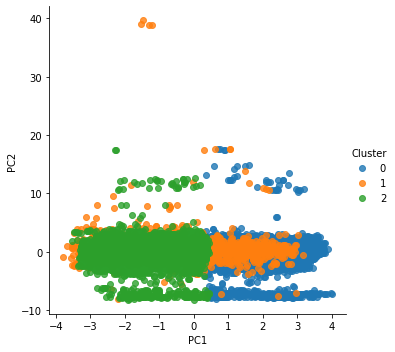

In [32]:
sns_pc_plot3 = sns.lmplot(x="PC1", y="PC2", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot3.savefig("Project_Data/Graphics/Cluster/"+ "sns_pc_plot3" + ".pdf")       

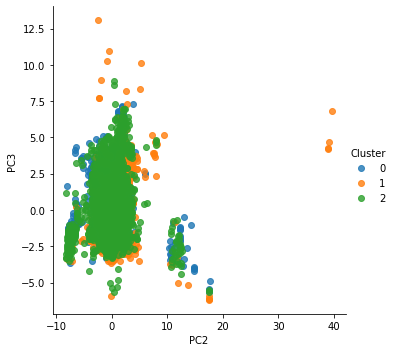

In [33]:
sns_pc_plot4 = sns.lmplot(x="PC2", y="PC3", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot4.savefig("Project_Data/Graphics/Cluster/" + "sns_pc_plot4" + ".pdf")       

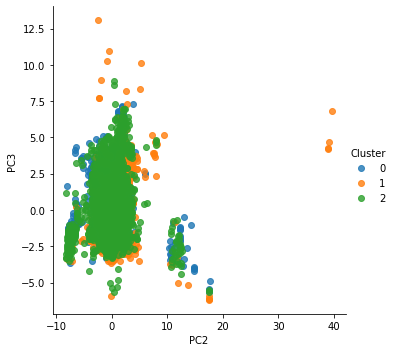

In [34]:
sns_pc_plot5 = sns.lmplot(x="PC2", y="PC3", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot5.savefig("Project_Data/Graphics/Cluster/"+ "sns_pc_plot5" + ".pdf")       